In [49]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [50]:
# beta should be higher than c
n = 585 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account
c = 1e-3 # numerator
beta = 1 # denominator
threshold = 0.5
sigma = 1.0 # from the normal DEPRECATED
n_iteration = 200
warm_up  = 50 # original 5

################################################

params_dict = {
    "n": n,
    "p": p,
    "c": c,
    "beta": beta,
    "threshold": threshold,
    "sigma": sigma,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [51]:
ut  = utils.GraphUtils()

graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation

In [104]:
g = graphs[-1]
s = spectra[-1]

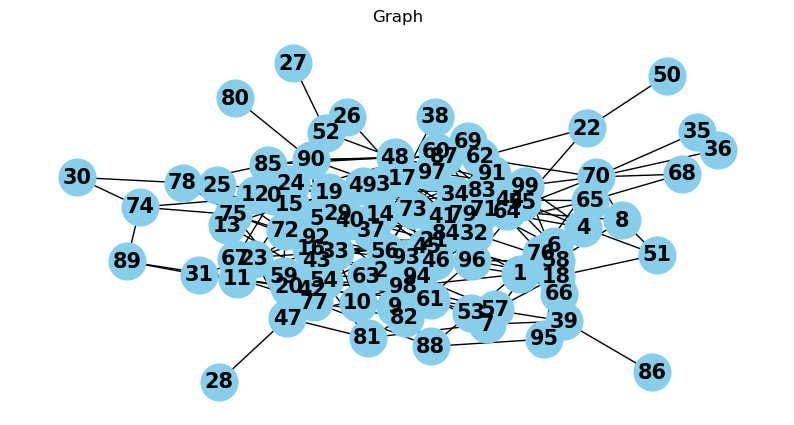

In [105]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

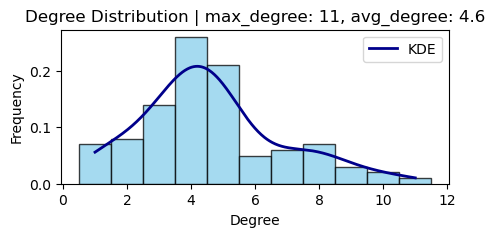

In [106]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [107]:
initial_guess = [0.1, 0.9]
est = estimator.MLEGraphModelEstimator(g)

#c_hat, beta_hat, result = est.estimate_parameters(initial_guess=initial_guess)

c_hat, beta_hat = est.estimate_parameters_torch(initial_guess=initial_guess, learning_rate=0.001, max_iter=30)

Current parameters: c=0.8593525886535645, beta=0.812873125076294, Loss=953.101318359375
Current parameters: c=0.6722039580345154, beta=0.9399223327636719, Loss=933.0050659179688
Current parameters: c=0.5735493898391724, beta=0.9762803316116333, Loss=896.5071411132812
Current parameters: c=0.5164875388145447, beta=0.984700083732605, Loss=887.987548828125
Current parameters: c=0.48457321524620056, beta=0.9800077080726624, Loss=885.3855590820312
Current parameters: c=0.4666585326194763, beta=0.9688738584518433, Loss=884.5548706054688
Current parameters: c=0.4555727243423462, beta=0.9545918703079224, Loss=884.166748046875
Current parameters: c=0.44742050766944885, beta=0.9387115836143494, Loss=883.8307495117188
Current parameters: c=0.44036370515823364, beta=0.9219040274620056, Loss=883.51708984375
Current parameters: c=0.43360498547554016, beta=0.9044285416603088, Loss=883.1734008789062
Current parameters: c=0.4268237352371216, beta=0.8863623738288879, Loss=882.8169555664062
Current param

In [109]:
print(c_hat,beta_hat)
print(c,beta)
#print(result)

0.18973766267299652 0.2698619067668915
0.001 1


In [110]:
est.likelihood_function([c_hat, beta_hat]), est.likelihood_function([c, beta]), est.likelihood_function([2,0])

(-852.5188167171152, -1271.3680905754281, nan)

## Plot

In [60]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


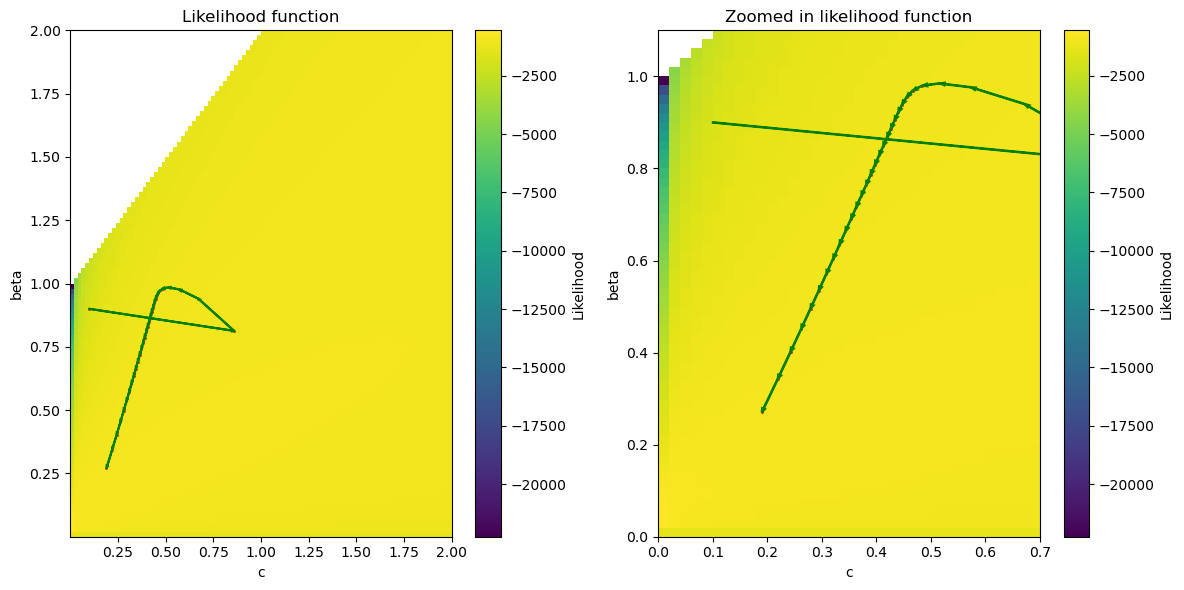

In [111]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()

# Log Reg

In [52]:
g = graphs[-1]
s = spectra[-1]
g


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
degree_i = np.sum(g, axis=1)  # Degree of each vertex i
degree_j = np.sum(g, axis=0)  # Degree of each vertex j
data = [{
    'i': i,
    'j': j,
    'degree_i': degree_i[i],
    'degree_j': degree_j[j],
    'edge_exists': bool(g[i, j])
} for i in range(g.shape[0]) for j in range(g.shape[1])]

df = pd.DataFrame(data)
df

,i,j,degree_i,degree_j,edge_exists
0,0,0,14.0,19.0,False
1,0,1,14.0,16.0,False
2,0,2,14.0,15.0,True
3,0,3,14.0,13.0,False
4,0,4,14.0,15.0,False
...,...,...,...,...,...
342220,584,580,16.0,15.0,False
342221,584,581,16.0,11.0,False
342222,584,582,16.0,12.0,False
342223,584,583,16.0,14.0,False


In [54]:
# Split the data into features and target variable
X = df[['degree_i', 'degree_j']]  # Features
y = df['edge_exists']  # Target variable

x = X.sum(axis=1).values
y = y.astype(float).values


In [55]:
import numpy as np
from scipy.optimize import minimize

def model(x, c, beta):
    return c / (1 + beta * np.exp(x))

# Negative log likelihood function
def neg_log_likelihood(params, x, y):
    c, beta = params
    probs = model(x, c, beta)
    # Avoiding log(0) by using a small epsilon value
    epsilon = 1e-10
    likelihood = y * np.log(probs + epsilon) + (1 - y) * np.log(1 - probs + epsilon)
    return -np.sum(likelihood)

# Initial parameter guess
initial_params = [1, 1]  # Initial guesses for c and beta

# Minimize the negative log likelihood
result = minimize(neg_log_likelihood, initial_params, args=(x, y))

# Estimated parameters
c_est, beta_est = result.x


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_49674/3615137652.py:13: RuntimeWarning: invalid value encountered in log
  likelihood = y * np.log(probs + epsilon) + (1 - y) * np.log(1 - probs + epsilon)
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_49674/3615137652.py:13: RuntimeWarning: invalid value encountered in log
  likelihood = y * np.log(probs + epsilon) + (1 - y) * np.log(1 - probs + epsilon)
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_49674/3615137652.py:13: RuntimeWarning: invalid value encountered in log
  likelihood = y * np.log(probs + epsilon) + (1 - y) * np.log(1 - probs + epsilon)


In [57]:
c_est, beta_est

(732.3197066867259, -730.3165280585163)